In [1]:
!pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 6.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [3]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
import scipy.stats as ss
from scipy import optimize
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import pandas as pd
from scipy.integrate import quad
from itertools import product
import statsmodels.api as sm

**Задание 1**

In [4]:
alpha = 0.05
z = ss.norm().ppf(1 - alpha/2)
n = 100000000
sample = ss.norm(loc=1/2).rvs(size=n, random_state=42)
significant_sample = sample[(sample < -z) | (sample > z)]
m_error = abs(2 * significant_sample).mean()
s_error = (significant_sample < 0).sum() / len(significant_sample)
power = len(significant_sample) / len(sample)
m_error, s_error, power

(4.788716458421993, 0.08789531267150259, 0.07908044)

**Задание 2**

In [27]:
data = pd.read_csv('view_proxy_randomization.csv')
data['w_vasya'] = 8 * data['category'] / 10 - 4
np.random.seed(1337)
model = sm.OLS(data['VIEW'], sm.add_constant(data['w_vasya'])).fit() 
print(model.summary())
print(f'sigma: {model.scale ** 0.5}')
# 114.6751 -1.2070 185.77132884241487

                            OLS Regression Results                            
Dep. Variable:                   VIEW   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     180.1
Date:                Fri, 18 Nov 2022   Prob (F-statistic):           4.65e-41
Time:                        16:12:27   Log-Likelihood:            -4.4293e+06
No. Observations:              666724   AIC:                         8.859e+06
Df Residuals:                  666722   BIC:                         8.859e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.6751      0.228    504.038      0.0

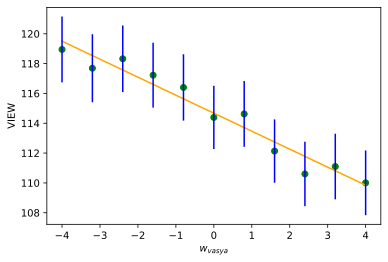

In [7]:
alpha = 0.05
k = 11
alpha_b = alpha / k
def draw_intervals():
  for cat in range(11):
    x = data[data['category'] == cat]['VIEW']
    n = len(x)
    t = ss.t(n - 1).ppf(1 - alpha_b / 2)
    interval = np.array([-t, t])
    interval = x.mean() + x.std(ddof=1) / np.sqrt(n) * interval
    ymin, ymax = interval
    plt.plot((8 * cat / 10 - 4, 8 * cat / 10 - 4), (ymin, ymax), color="blue")

grid = 8 * np.arange(11) / 10 - 4
x = pd.DataFrame({'w_vasya': np.linspace(-4,4,100)})
plt.plot(x, model.predict(sm.add_constant(x)), color="orange")
plt.scatter(grid, np.array([data[data['category'] == cat]['VIEW'].mean() for cat in range(11)]), color='green')
draw_intervals()
plt.xlabel("$w_{vasya}$")
plt.ylabel("VIEW")
plt.show()

Вася ожидал, что чем меньше $w_{vasya}$ (вес при $\mathbb{P}(bounce|\dots)$ в в его эксперименте), тем будет больше просмотров. Так, вроде, и получилось: если взять двух случайных пользователей с разницей в весовом коэффициенте $w_{vasya}$ равной 1, то в среднем у пользователя с большим $w_{vasya}$ просмотры меньше на 1.2070. При этом разброс $\sigma \approx 185$ соизмерим с самими предсказаниями, это просто значит, что по $w_{vasya}$ не имеет смысла предсказывать число просмотров, потому что оно много от чего зависит.

**Задание 3**

In [36]:
data = pd.read_csv("body_temp.csv")
data['heart rate - average heart rate'] = data['heart rate'] - data['heart rate'].mean()
np.random.seed(1337)
model = sm.OLS(data['body temperature'], sm.add_constant(data[['sex', 'heart rate - average heart rate']])).fit() 
print(model.summary())
print(f'sigma: {model.scale ** 0.5}')
# 36.5793 0.1523 0.0138 0.390163199262482

                            OLS Regression Results                            
Dep. Variable:       body temperature   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     6.830
Date:                Fri, 18 Nov 2022   Prob (F-statistic):            0.00152
Time:                        16:47:33   Log-Likelihood:                -60.590
No. Observations:                 130   AIC:                             127.2
Df Residuals:                     127   BIC:                             135.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

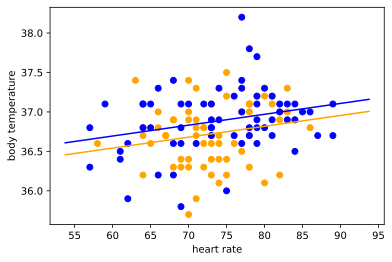

In [33]:
x = data[data['sex'] == 1]
y = data[data['sex'] == 2]
plt.scatter(x['heart rate - average heart rate'] + data['heart rate'].mean(), x['body temperature'], color="orange")
plt.scatter(y['heart rate - average heart rate'] + data['heart rate'].mean(), y['body temperature'], color="blue")
plt.xlabel('heart rate')
plt.ylabel('body temperature')
n = 100
X = pd.DataFrame({'const': np.ones(n), 'sex': np.ones(n), 'heart rate - average heart rate': np.linspace(-20, 20, n)})
Y = pd.DataFrame({'const': np.ones(n), 'sex': 2 * np.ones(n), 'heart rate - average heart rate': np.linspace(-20, 20, n)})
plt.plot(X['heart rate - average heart rate'] + data['heart rate'].mean(), model.predict(X), color="orange")
plt.plot(Y['heart rate - average heart rate'] + data['heart rate'].mean(), model.predict(Y), color="blue")
plt.show()

Коэффициент при $sex$ получился равным $0.1523$. Это значит, что у двух случайно выбранных мужчины и женщины с одинаковой частотой сердцебиения температура тела в среднем отличается на $0.1523$ градус. А средняя температура
мужчин и женщин $36.73$ и $36.88$.

При этом у двух случайных людей одинакого пола, у одного из которых на $10$ ударов в минуту больше, то в среднем у человека с большей частотой сердцебиения температура больше на $0.138$ градус.

**Задание 4**

In [38]:
data = pd.read_csv('birthweight.csv')
data['mheight'] = 2.54 * data['mheight'] #дюйм
data['Birthweight'] = 0.453592 * data['Birthweight'] # фунт
data['Gestation - average Gestation'] = data['Gestation'] - data['Gestation'].mean()
data['mheight - average mheight'] = data['mheight'] - data['mheight'].mean()
np.random.seed(1337)
model = sm.OLS(data['Birthweight'],
               sm.add_constant(data[['smoker', 'Gestation - average Gestation', 'mheight - average mheight']]
                               )).fit() 
print(model.summary())
print(f'sigma: {model.scale ** 0.5}')
# 3.4567 -0.3087 0.1433 0.0217 0.39164223884514593

                            OLS Regression Results                            
Dep. Variable:            Birthweight   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     19.75
Date:                Fri, 18 Nov 2022   Prob (F-statistic):           7.01e-08
Time:                        16:48:45   Log-Likelihood:                -18.123
No. Observations:                  42   AIC:                             44.25
Df Residuals:                      38   BIC:                             51.20
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

Средний вес новорожденного равен: $3.45 кг$.

У курящих людей вес новоржденного в среденем на $301г$ меньше.

У матерей, которые вынашивали ребенка на неделю больше, при всех прочих равных
вес ребенка в среднем на $143$ грамма больше.

Матери, которые на $1см$ выше, при всех прочих равных рожают
ребенка весом в среднем на $22$ грамма больше.


**Задание 5**

In [18]:
data = pd.read_csv('cars.csv')
data['log Horsepower'] = np.log(data['Horsepower'])
data['log Suggested Retail Price'] = np.log(data['Suggested Retail Price'])
np.random.seed(1337)
model = sm.OLS(data['log Suggested Retail Price'],
               sm.add_constant(data['log Horsepower']
                               )).fit() 
print(model.summary())
print(f'sigma: {model.scale ** 0.5}')
# b = 1.2843

                                OLS Regression Results                                
Dep. Variable:     log Suggested Retail Price   R-squared:                       0.752
Model:                                    OLS   Adj. R-squared:                  0.752
Method:                         Least Squares   F-statistic:                     1294.
Date:                        Fri, 18 Nov 2022   Prob (F-statistic):          3.64e-131
Time:                                15:15:46   Log-Likelihood:               0.089390
No. Observations:                         428   AIC:                             3.821
Df Residuals:                             426   BIC:                             11.94
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

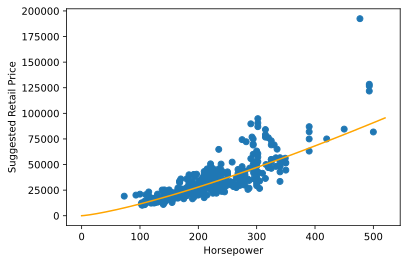

In [20]:
plt.scatter(data['Horsepower'], data['Suggested Retail Price'])
plt.xlabel('Horsepower')
plt.ylabel('Suggested Retail Price')
x = pd.DataFrame({'Horsepower': np.linspace(0,520, 1000)})
plt.plot(x, np.exp(model.predict(sm.add_constant(np.log(x)))), color='orange')
plt.show()

Если рассмотреть 2 случаные машины: у одной в 2 раза больше лошадиных сил и все остальные параметры равны, то в среднем у более мощной машины рекомендованная розничная цена больше в $2^b \approx 2.4356$ раза.